## Interpreter Random Forest - Regression

In this article, I will summarize some techniques I learned to interpret the result of random forest regression.

### A Basic Model

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
cat_cols = tips.select_dtypes('category')
for col in cat_cols:
    tips[col] = tips[col].cat.codes

In [4]:
train, test = train_test_split(tips, test_size = 0.2)

In [5]:
train_features = train.drop('tip', axis=1)
train_labels = train['tip']

In [6]:
mod_rf = RandomForestRegressor(random_state=42)

In [7]:
mod_rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [8]:
test_features = test.drop('tip', axis=1)
test_labels = test['tip']

In [9]:
test_pred = mod_rf.predict(test_features)

In [10]:
mean_squared_error(test_labels, test_pred)

0.7623281463265303

### Overall Interpretation

#### Feature Importance - impurity

In [20]:
def get_feature_imp(df, mod_rf):
    result = pd.DataFrame()
    result['name'] = df.columns
    result['score'] = mod_rf.feature_importances_
    return result.sort_values('score', ascending=False)

In [21]:
impurity_imp = get_feature_imp(train_features, mod_rf)

In [22]:
impurity_imp

,name,score
0,total_bill,0.783710
5,size,0.070502
2,smoker,0.061751
3,day,0.052399
1,sex,0.020007
4,time,0.011632


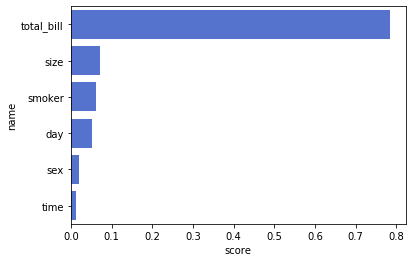

In [38]:
sns.barplot(x="score", y="name", data=impurity_imp, color="royalblue");

#### Feature Importance - accuracy

In [13]:
from sklearn.inspection import permutation_importance

In [24]:
permutation_imp = permutation_importance(mod_rf, train_features, train_labels, n_repeats=5, random_state=42)

In [29]:
per_imp_df = pd.DataFrame()
per_imp_df['name'] = train_features.columns
per_imp_df['score'] = permutation_imp.importances_mean
per_imp_df = per_imp_df.sort_values('score', ascending=False)

In [30]:
per_imp_df

,name,score
0,total_bill,1.381693
2,smoker,0.156832
5,size,0.110709
3,day,0.093154
1,sex,0.027546
4,time,0.013014


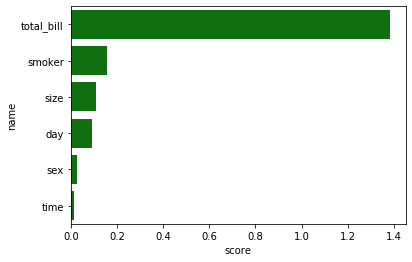

In [43]:
sns.barplot(x="score", y="name", data=per_imp_df, color="green");

### Local Interpretation

#### Tree Interpreter

In [74]:
from treeinterpreter import treeinterpreter as ti

/Users/martinpan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [75]:
instances = test_features.values[0].reshape(1,-1)
prediction, biases, contributions = ti.predict(mod_rf, instances)

In [77]:
print("Prediction", prediction)
print("Bias (trainset prior)", biases)
print("Feature contributions:")
for c, feature in zip(contributions[0], test_features.columns):
    print(feature, c)

Prediction [[1.7413]]
Bias (trainset prior) [3.02901385]
Feature contributions:
total_bill -1.2341190951281797
sex 0.017024069316967115
smoker -0.08998773197446364
day 0.01713674799909176
time 0.00870066310323663
size -0.00646849947049839


#### LIME

In [86]:
import lime

In [94]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_features.values, feature_names=list(train_features.columns), class_names=['tip'],
                                                   verbose=True, mode='regression')

In [95]:
i = 0
exp = explainer.explain_instance(test_features.values[i], mod_rf.predict, num_features=5)

IndexError: index 6 is out of bounds for axis 0 with size 6

### Partial Depedence

In [44]:
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence

In [49]:
train_features.columns[0]

'total_bill'

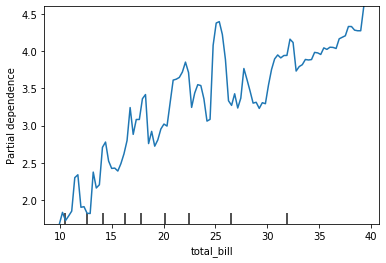

In [69]:
plot_partial_dependence(mod_rf, train_features, [0]);

In [72]:
pred, values = partial_dependence(mod_rf, train_features, [0])

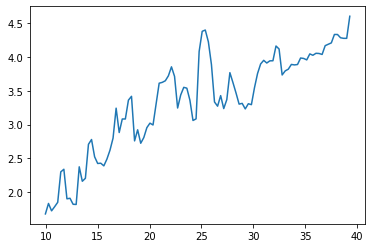

In [73]:
sns.lineplot(x=values[0], y=pred[0]);

This method also works for categorical variable.

In [ ]:
train_features.columns[1]

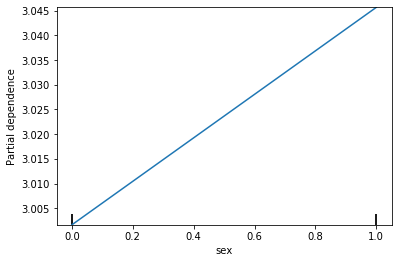

In [50]:
plot_partial_dependence(mod_rf, train_features, [1]);